In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.networks import value_rnn_network
from tf_agents.agents import PPOAgent
from tf_agents.utils import common as cmn

import matplotlib.pyplot as plt
import qutip
from qutip import expect, basis, sigmap, sigmam, fidelity

from tqdm.auto import trange
import time

import random

import sys
sys.path.append('../')
from common.common import get_average_return, extract_trigonometric_controls

%matplotlib inline

In [9]:
T = 3.15 # terminal time step
max_steps = 300 # number of time steps
random.seed(1989)
tf.random.set_seed(1989)

In [10]:
# validate environment
from environments.qubit_cont_func_env import QubitContEnvContFunc

# define actions
# actions can be represented as trigonometric series, we are searching for optimal parameters
max_Ω = 1.0
max_Δ = 0.5

environment = QubitContEnvContFunc(T, max_steps, max_Ω, max_Δ = max_Δ, fidelity_threshold = 0.999, verbose_fg = False, nb_harmonics = 3)
eval_environment = QubitContEnvContFunc(T, max_steps, max_Ω, max_Δ = max_Δ, fidelity_threshold = 0.999, verbose_fg = False, nb_harmonics = 3)

train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

In [11]:
fc_layer_params = (100, 100, 50)
learning_rate = 2e-3
replay_buffer_capacity = 100000
num_iterations = 10000
nb_episodes = 1
eval_interval = 10
checkpoint_dir = "../checkpoints/ppo_qubit_trigonometric_series/"

In [12]:
actor_network = actor_distribution_network.ActorDistributionNetwork(
    input_tensor_spec = train_env.observation_spec(),
    output_tensor_spec = train_env.action_spec(),
    fc_layer_params = fc_layer_params,
    activation_fn = tf.keras.activations.relu,
    name = "Policy",
)

# use tha Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

train_step_counter = tf.Variable(0)

value_net = value_network.ValueNetwork(
    input_tensor_spec = train_env.observation_spec(),
    fc_layer_params = (75, 75, 50),
    name = 'ValueNet'
)

agent = PPOAgent(
    time_step_spec = train_env.time_step_spec(),
    action_spec = train_env.action_spec(),
    actor_net = actor_network,
    value_net = value_net,
    optimizer = optimizer,
    train_step_counter = train_step_counter,
)

agent.initialize()

In [13]:
# collect trajectories
import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_capacity,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = None,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = cmn.function(agent.train)

# Reset the train step.
# agent.train_step_counter.assign(0)

# create a driver which will run the simulations and collect tha dataset for our training
collect_driver = py_driver.PyDriver(
    environment,
    py_tf_eager_policy.PyTFEagerPolicy(agent.collect_policy, use_tf_function = True),
    observers = [rb_observer],
    max_episodes = nb_episodes
)

# create checkpointer to load training and continue
""" checkpointer = cmn.Checkpointer(
    ckpt_dir = checkpoint_dir,
    max_to_keep = 1,
    agent = agent,
    policy = agent.policy,
    replay_buffer = replay_buffer,
)

checkpointer.initialize_or_restore() """

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpkutexh8j.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpkutexh8j
[reverb/cc/platform/default/server.cc:71] Started replay server on port 40399
[reverb/cc/platform/default/server.cc:84] Shutting down replay server


' checkpointer = cmn.Checkpointer(\n    ckpt_dir = checkpoint_dir,\n    max_to_keep = 1,\n    agent = agent,\n    policy = agent.policy,\n    replay_buffer = replay_buffer,\n)\n\ncheckpointer.initialize_or_restore() '

In [14]:
with trange(num_iterations, dynamic_ncols = False) as tbar:
    for _ in tbar:
        initial_time_step = environment.reset()
        collect_driver.run(initial_time_step)

        # if threshold fidelity achieved, stop training
        if environment.max_fidelity >= 0.999:
            break

        # create dataset from trajectories
        dataset = replay_buffer.as_dataset(sample_batch_size = 1)
        iterator = iter(dataset)

        trajectories , _ = next(iterator)

        # train 
        train_loss = agent.train(experience = trajectories)

        replay_buffer.clear()

        step = agent.train_step_counter.numpy()

        if step % 10 == 0:
            tbar.set_postfix({"step": step, "loss": train_loss.loss.numpy(), "max fidelity": environment.max_fidelity})

 10%|█         | 1014/10000 [03:15<28:50,  5.19it/s, step=25350, loss=-1.6, max fidelity=0.999] 

 fidelity   =  0.99966 [ 0.86193289  0.152197    0.19752197 -0.00489036 -0.05913138 -0.10916921
  0.03801898] [ 0.06261037 -0.08266446 -0.11288086 -0.09862257  0.31972828 -0.02207027
  0.20511899]


In [15]:
omega_params = environment.optimal_omega_params
detuning_params = environment.optimal_detuning_params
states = environment.states
desired_state = basis(2, 1)
fidelities = [fidelity(desired_state, state) ** 2 for state in states]

nb_harmonics = environment._nb_harmonics

def omega(t, args):
    Ω = omega_params[0]

    for harmonic in range(1, nb_harmonics + 1):
        Ω += omega_params[2 * harmonic - 1] * np.cos(harmonic * t) + omega_params[2 * harmonic] * np.sin(harmonic * t)

    return Ω

def detuning(t, args):
    Δ = detuning_params[0]

    for harmonic in range(1, nb_harmonics + 1):
        Δ += detuning_params[2 * harmonic - 1] * np.cos(harmonic * t) + detuning_params[2 * harmonic] * np.sin(harmonic * t)

    return Δ

time_span = np.linspace(start = 0, stop = T, num = max_steps)

omegas = [omega(t, args = None) for t in time_span]
detunings = [detuning(t, args = None) for t in time_span]

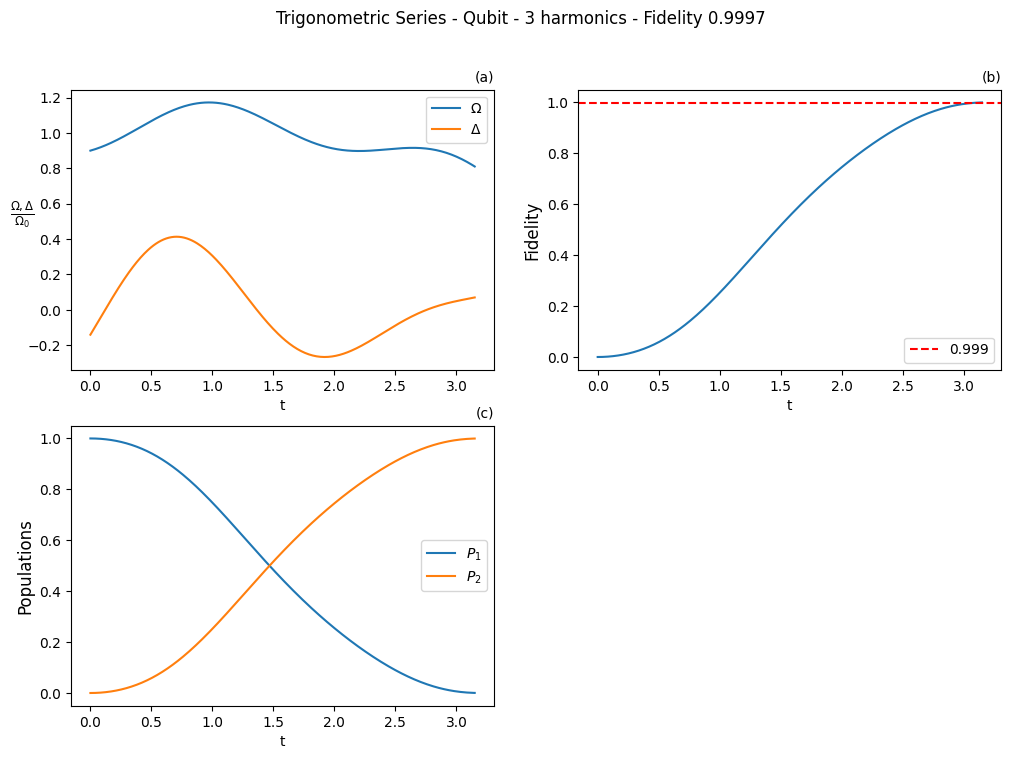

In [16]:
population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig = plt.figure()
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, :-1])
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f"Trigonometric Series - Qubit - {nb_harmonics} harmonics - Fidelity {round(environment.max_fidelity, 4)}")

ax1.plot(time_span, omegas, label = 'Ω')
ax1.plot(time_span, detunings, label = 'Δ')
ax1.set_ylabel(r"$\frac{Ω,Δ}{\Omega_0}$", rotation = 0, fontsize = 12)
ax1.set_xlabel(r"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)
ax1.legend()

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.999, color = 'r', linestyle = '--', label = '0.999')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(r"t")
ax2.set_title("(b)", loc = "right", fontsize = 10)
ax2.legend(loc = 'lower right')

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(r"t")
ax4.set_title("(c)", loc = "right", fontsize = 10)
ax4.legend()

In [17]:
fidelities

[0.0,
 2.25302255541371e-05,
 9.033226352614083e-05,
 0.00020373427399824086,
 0.00036307939394101207,
 0.0005687254656557122,
 0.0008210447216635909,
 0.0011204234258010834,
 0.0014672614700309537,
 0.0018619719178878163,
 0.0023049780977289357,
 0.002796719624919764,
 0.0033376459115893424,
 0.0039282173214860204,
 0.004568904504481089,
 0.005260187688150048,
 0.006002555926978055,
 0.006796506309831558,
 0.007642543126440283,
 0.008541176993742917,
 0.009492923943067489,
 0.010498304469247556,
 0.011557842542925006,
 0.012672064587469549,
 0.013841498422163676,
 0.015066672173552101,
 0.01634811315707617,
 0.017686346731160856,
 0.019081895125609902,
 0.020535276245524953,
 0.02204700245151156,
 0.023617579317348248,
 0.025247504367527544,
 0.026937265798200122,
 0.02868734118535715,
 0.030498196183753493,
 0.03237028321966089,
 0.03430404018033942,
 0.03629988910311496,
 0.038358234867050846,
 0.04047946389031618,
 0.042663942836454985,
 0.04491201733283712,
 0.047224010704624064,


In [ ]:
omega_params

In [ ]:
detuning_params